# Scripts developing code for calculating the EHF

In [1]:
import numpy as np

import xarray as xr

from src import utils
from src.prepare_data import _open

import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [31]:
DATA_PATH = "../../data/exploratory/"

## Cluster

In [64]:
from distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-q express",
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83",
    ],
    local_directory="$PBS_JOBFS",
    header_skip=["select"],
)

cluster.scale(jobs=1)
client = Client(cluster)
print(f"Dask daskboard link: {client.dashboard_link}")

Dask daskboard link: http://10.6.71.36:8787/status


## Develop functions on some AGCD data

In [33]:
%%time

compute = False

if compute:
    agcd = _open.AGCD(["tmin", "tmax"], None, None)

    utils.calculate_tmean_from_tmin_tmax(
        agcd.sel(time=slice("1958",None))
    ).chunk({"time": -1}).to_zarr(f"{DATA_PATH}/agcd_tmean.zarr", mode="w")

agcd = xr.open_zarr(f"{DATA_PATH}/agcd_tmean.zarr", use_cftime=True)

CPU times: user 343 ms, sys: 0 ns, total: 343 ms
Wall time: 344 ms


### Calculate EHF

In [135]:
def calculate_EHF(
    T,
    T_p95=None,
    T_p95_period=None,
    T_p95_dim=None,
    rolling_dim="time",
):
    """
    Calculate the Excess Heat Factor (EHF) index, defined as:

        EHF = max(0, EHI_sig) * max(1, EHI_accl)

    with

        EHI_sig = (T_i + T_i+1 + T_i+2) / 3 – T_p95
        EHI_accl = (T_i + T_i+1 + T_i+2) / 3 – (T_i–1 + ... + T_i–30) / 30

    T is the daily mean temperature (commonly calculated as the mean of the min and max
    daily temperatures, usually with daily maximum typically preceding the daily minimum,
    and the two observations relate to the same 9am-to-9am 24-h period) and T_p95 is the 95th
    percentile of T using all days in the year.

    Parameters
    ----------
    T : xarray DataArray
        Array of daily mean temperature
    T_p95 : xarray DataArray, optional
        Array of the 95th percentile of T using all days in the year. If not provided, T_p95_period
        and T_p95_dim must be provided
    T_p95_period : list of str, optional
        Size 2 iterable containing strings indicating the start and end dates of the period over
        which to calculate T_p95. Only used if T_p95 is None
    T_p95_dim : str or list of str, optional
        The dimension(s) over which to calculate T_p95. Only used if T_p95 is None
    rolling_dim : str, optional
        The dimension over which to compute the rolling averages in the definition of EHF

    References
    ----------
    Nairn et al. 2015: https://doi.org/10.3390/ijerph120100227
    """

    if T_p95 is None:
        if (T_p95_period is not None) & (T_p95_dim is not None):
            T_p95 = utils.calculate_percentile_thresholds(
                T, 0.95, T_p95_period, T_p95_dim, frequency=None
            )
        else:
            raise ValueError(
                (
                    "Must provide either thresholds of the 95th percentile of temperature (T_p95) "
                    "or details of the climatological period and dimensions to use to calculate these "
                    "thresholds (T_p95_period and T_p95_dim)"
                )
            )

    T_3d = (
        T.rolling({rolling_dim: 3}, min_periods=3).mean().shift({rolling_dim: -2})
    )  # Shift so that referenced to first day in window
    T_30d = (
        T.rolling({rolling_dim: 30}, min_periods=30).mean().shift({rolling_dim: 1})
    )  # Shift so that referenced to day after last day in window

    EHI_sig = T_3d - T_p95
    EHI_accl = T_3d - T_30d
    EHF = EHI_sig * EHI_accl.where(EHI_accl > 1, 1)

    EHF = EHF.rename("EHF")
    EHF.attrs["long_name"] = "Excess Heat Factor"
    EHF.attrs["standard_name"] = "excess_heat_factor"
    EHF.attrs["units"] = "K^2"

    return EHF


def calculate_EHF_severity(
    T,
    T_p95=None,
    EHF_p85=None,
    T_p95_period=None,
    T_p95_dim=None,
    EHF_p85_period=None,
    EHF_p85_dim=None,
    rolling_dim="time",
):
    """
    Calculate the severity of the Excess Heat Factor index, defined as:

        EHF_severity = EHF / EHF_p85

    where "_p85" denotes the 85th percentile of all positive values using all days in the
    year and the Excess Heat Factor (EHF) is defined as:

        EHF = max(0, EHI_sig) * max(1, EHI_accl)

    with

        EHI_sig = (T_i + T_i+1 + T_i+2) / 3 – T_p95
        EHI_accl = (T_i + T_i+1 + T_i+2) / 3 – (T_i–1 + ... + T_i–30) / 30

    T is the daily mean temperature (commonly calculated as the mean of the min and max
    daily temperatures, usually with daily maximum typically preceding the daily minimum,
    and the two observations relate to the same 9am-to-9am 24-h period) and T_p95 is the 95th
    percentile of T using all days in the year.

    Parameters
    ----------
    T : xarray DataArray
        Array of daily mean temperature
    T_p95 : xarray DataArray, optional
        Array of the 95th percentile of T using all days in the year. If not provided, T_p95_period
        and T_p95_dim must be provided
    EHF_p85 : xarray DataArray, optional
        Array of the 85th percentile of positive EHF values using all days in the year to be used to
        quantify the severity of the EHF. If not provided, EHF_p85_period and EHF_p85_dim must be
        provided
    T_p95_period : list of str, optional
        Size 2 iterable containing strings indicating the start and end dates of the period over
        which to calculate T_p95. Only used if T_p95 is None
    T_p95_dim : str or list of str, optional
        The dimension(s) over which to calculate T_p95. Only used if T_p95 is None
    EHF_p85_period : list of str, optional
        Size 2 iterable containing strings indicating the start and end dates of the period over
        which to calculate EHF_p85. Only used if EHF_p85 is None
    EHF_p85_dim : str or list of str, optional
        The dimension(s) over which to calculate EHF_p85. Only used if EHF_p85 is None
    rolling_dim : str, optional
        The dimension over which to compute the rolling averages in the definition of EHF

    References
    ----------
    Nairn et al. 2015: https://doi.org/10.3390/ijerph120100227
    """

    if EHF_p85 is None:
        if (EHF_p85_period is not None) & (EHF_p85_dim is not None):
            calculate_EHF_p85 = True
        else:
            raise ValueError(
                (
                    "Must provide either thresholds of the 85th percentile of EHF (E_p85) or details "
                    "of the climatological period and dimensions to use to calculate these thresholds "
                    "(EHF_p85_period and EHF_p85_dim)"
                )
            )
    else:
        calculate_EHF_p85 = False

    EHF = calculate_EHF(T, T_p95, T_p95_period, T_p95_dim, rolling_dim)

    if calculate_EHF_p85:
        EHF_p85 = utils.calculate_percentile_thresholds(
            EHF.where(EHF > 0), 0.85, EHF_p85_period, EHF_p85_dim, frequency=None
        )

    EHF_sev = EHF / EHF_p85

    EHF_sev = EHF_sev.rename("EHF_severity")
    EHF_sev.attrs["long_name"] = "Severity of the Excess Heat Factor"
    EHF_sev.attrs["standard_name"] = "excess_heat_factor_severity"
    EHF_sev.attrs["units"] = "-"

    return EHF_sev

In [137]:
%%time

compute = False

if compute:
    calculate_EHF(
        agcd["tmean"],
        T_p95_period=["1971-01-01", "2000-12-31"],
        T_p95_dim="time",
    ).to_dataset().to_zarr(f"{DATA_PATH}/agcd_EHF.zarr", mode="w")
    
    calculate_EHF_severity(
        agcd["tmean"],
        T_p95_period=["1971-01-01", "2000-12-31"],
        T_p95_dim="time",
        EHF_p85_period=["1958-01-01", "2011-12-31"],
        EHF_p85_dim="time",
    ).to_dataset().to_zarr(f"{DATA_PATH}/agcd_EHF_severity.zarr", mode="w")

agcd["EHF"] = xr.open_zarr(f"{DATA_PATH}/agcd_EHF.zarr", use_cftime=True)["EHF"]
agcd["EHF_severity"] = xr.open_zarr(f"{DATA_PATH}/agcd_EHF_severity.zarr", use_cftime=True)["EHF_severity"]

CPU times: user 960 ms, sys: 20.2 ms, total: 980 ms
Wall time: 1.16 s


### Check the output by comparing to results in Nairn et al. (2015)

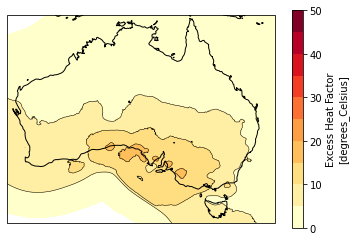

In [131]:
import cartopy.crs as ccrs

Fig_6 = (
    agcd["EHF"]
    .where(agcd["EHF"] > 0)
    .sel(time=slice("1958-01-01", "2011-12-31"))
    .mean("time")
).compute()

Fig_6.plot.contourf(
    levels=11,
    vmin=0,
    vmax=50,
    cmap="YlOrRd",
    subplot_kws=dict(projection=ccrs.PlateCarree(180)),
    transform=ccrs.PlateCarree(),
)
p = Fig_6.plot.contour(
    levels=11,
    vmin=0,
    vmax=50,
    colors="k",
    linewidths=0.5,
    subplot_kws=dict(projection=ccrs.PlateCarree(180)),
    transform=ccrs.PlateCarree(),
)

p.axes.coastlines()
_ = plt.title("")

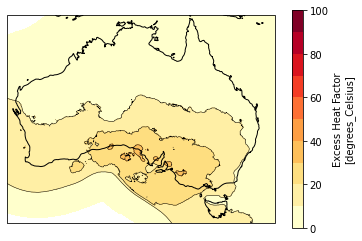

In [133]:
Fig_8 = utils.calculate_percentile_thresholds(
    agcd["EHF"].where(agcd["EHF"] > 0),
    0.85,
    ["1958-01-01", "2011-12-31"],
    "time",
    frequency=None,
).compute()

Fig_8.plot.contourf(
    levels=11,
    vmin=0,
    vmax=100,
    cmap="YlOrRd",
    subplot_kws=dict(projection=ccrs.PlateCarree(180)),
    transform=ccrs.PlateCarree(),
)
p = Fig_8.plot.contour(
    levels=11,
    vmin=0,
    vmax=100,
    colors="k",
    linewidths=0.5,
    subplot_kws=dict(projection=ccrs.PlateCarree(180)),
    transform=ccrs.PlateCarree(),
)

p.axes.coastlines()
_ = plt.title("")

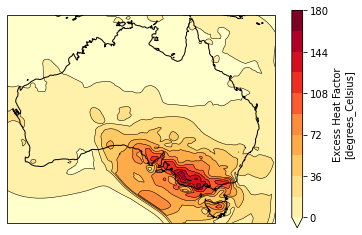

In [138]:
Fig_16 = agcd["EHF"].sel(time=slice("2009-01-21", "2009-02-09")).max("time").compute()

Fig_16.plot.contourf(
    levels=11,
    vmin=0,
    vmax=180,
    cmap="YlOrRd",
    subplot_kws=dict(projection=ccrs.PlateCarree(180)),
    transform=ccrs.PlateCarree(),
)
p = Fig_16.plot.contour(
    levels=11,
    vmin=0,
    vmax=180,
    colors="k",
    linewidths=0.5,
    subplot_kws=dict(projection=ccrs.PlateCarree(180)),
    transform=ccrs.PlateCarree(),
)

p.axes.coastlines()
_ = plt.title("")

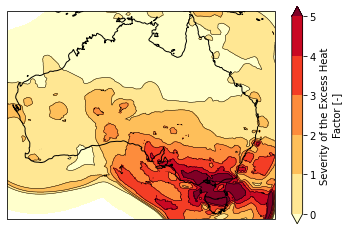

In [147]:
# Fig_17 = (
#     agcd["EHF_severity"]
#     .sel(time=slice("2009-01-21", "2009-02-09"))
#     .max("time")
#     .compute()
# )

Fig_17.plot.contourf(
    levels=6,
    vmin=0,
    vmax=5,
    cmap="YlOrRd",
    subplot_kws=dict(projection=ccrs.PlateCarree(180)),
    transform=ccrs.PlateCarree(),
)
p = Fig_17.plot.contour(
    levels=6,
    vmin=0,
    vmax=5,
    colors="k",
    linewidths=0.5,
    subplot_kws=dict(projection=ccrs.PlateCarree(180)),
    transform=ccrs.PlateCarree(),
)

plt.plot(145, -38, "k+", transform=ccrs.PlateCarree())

p.axes.coastlines()
_ = plt.title("")

In [158]:
test = agcd["EHF_severity"].sel(lon=145, lat=-38, method="nearest").compute()

In [159]:
test_anom = test.groupby("time.dayofyear").map(lambda x: x - x.mean("time"))

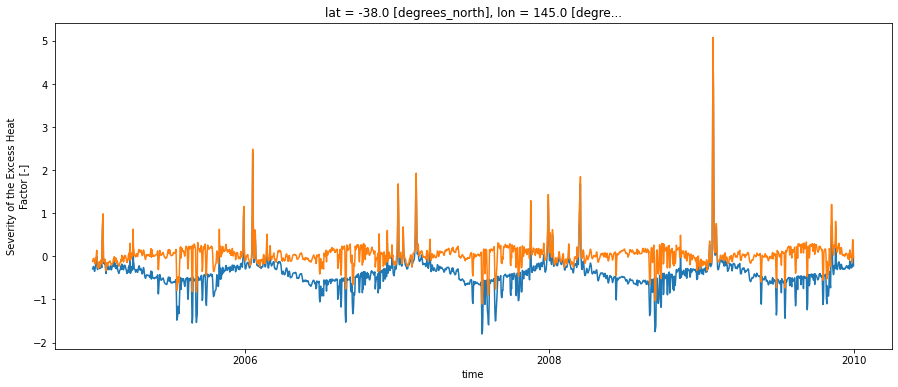

In [165]:
fig = plt.figure(figsize=(15, 6))
test.sel(time=slice("2005-01-01", "2009-12-31")).plot()
test_anom.sel(time=slice("2005-01-01", "2009-12-31")).plot()

In [154]:
cluster.close()
client.close()